In [1]:
from config_figures import *
from scipy.stats import gaussian_kde
from math import floor, ceil

In [2]:
def get_area_lat_elev_df(drive_filename):
    df = pd.read_csv(google_drive_path + '/' + drive_filename + '.csv').drop(['system:index', '.geo'], axis=1)
    df = df[df['area_1981_2010'] != 0]
    df['area_1981_2010_1e6km2'] = df['area_1981_2010'] / 1e12
    return df[['species','area_1981_2010_1e6km2','latitude_1981_2010']]

def compute_area_lat_rolling_average(df, step, window):
    latitudes = np.arange(floor(df['latitude_1981_2010'].min()), ceil(df['latitude_1981_2010'].max()), step)
    median_area = [df[(df['latitude_1981_2010'] >= lat) & (df['latitude_1981_2010'] < lat+step)]['area_1981_2010_1e6km2'].median() for lat in latitudes]
    rolling_average_df = pd.DataFrame(data={'lat': latitudes, 'median_area': median_area}, index=None)
    rolling_average_df['rolling_average'] = rolling_average_df.median_area.rolling(window).mean()
    return rolling_average_df

def area_latitude_scatterplot(df, xlabel='SDM area (1e6 km2)', step=1, window=4, filename_to_save=None):
    x = df['area_1981_2010_1e6km2']
    y = df['latitude_1981_2010']
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    fig=plt.figure(figsize=(4,6))
    plt.scatter(x, y, c=z, s=1)
    plt.set_cmap('viridis')

    rolling_average_df = compute_area_lat_rolling_average(df, step, window)
    plt.plot(rolling_average_df['rolling_average'], rolling_average_df['lat'], 'r')

    plt.xlabel(xlabel)
    plt.ylabel('Median SDM latitude')
    if filename_to_save is not None : plt.savefig('../figures/' + filename_to_save)
    else: plt.show()

In [3]:
df_global = get_area_lat_elev_df(sdms_area_lat_elev_drive_filename)
df_global

,species,area_1981_2010_1e6km2,latitude_1981_2010
0,Abarema_barbouriana,0.941661,3.628973
1,Abarema_brachystachya,0.804058,-20.127242
2,Abarema_cochleata,0.579152,-2.438856
3,Abarema_filamentosa,0.303746,-12.438020
4,Abarema_jupunba,3.035330,2.124966
...,...,...,...
10585,Zygia_latifolia,4.536488,-0.876385
10586,Zygia_longifolia,1.311062,5.378190
10587,Zygia_racemosa,1.998093,0.374126
10588,Zygia_unifoliolata,2.838407,-0.874904


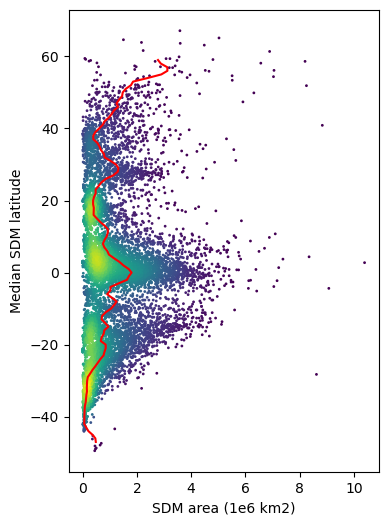

In [5]:
area_latitude_scatterplot(df_global)#filename_to_save='area_latitude_scatterplot_global.png')

In [6]:
df_forest = get_area_lat_elev_df(sdms_forest_area_lat_elev_drive_filename)
df_forest

,species,area_1981_2010_1e6km2,latitude_1981_2010
0,Abarema_barbouriana,0.919650,3.628381
1,Abarema_brachystachya,0.583012,-20.126729
2,Abarema_cochleata,0.511100,-2.438659
3,Abarema_filamentosa,0.212112,-12.685654
4,Abarema_jupunba,2.873850,2.124942
...,...,...,...
10585,Zygia_latifolia,4.073369,-0.629770
10586,Zygia_longifolia,1.218121,5.378197
10587,Zygia_racemosa,1.946435,0.374169
10588,Zygia_unifoliolata,2.536577,-1.126276


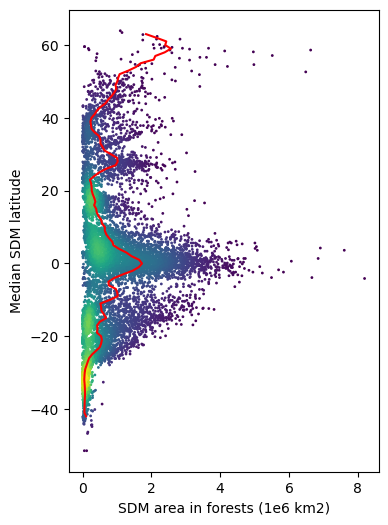

In [8]:
area_latitude_scatterplot(df_forest, xlabel='SDM area in forests (1e6 km2)')#, filename_to_save='area_latitude_scatterplot_forest.png')

In [9]:
df = df_global.merge(df_forest, on='species', suffixes=('_global', '_forest'))
df['area_decrease'] = (df['area_1981_2010_1e6km2_global'] - df['area_1981_2010_1e6km2_forest']) / df['area_1981_2010_1e6km2_global']
df

,species,area_1981_2010_1e6km2_global,latitude_1981_2010_global,area_1981_2010_1e6km2_forest,latitude_1981_2010_forest,area_decrease
0,Abarema_barbouriana,0.941661,3.628973,0.919650,3.628381,0.023375
1,Abarema_brachystachya,0.804058,-20.127242,0.583012,-20.126729,0.274914
2,Abarema_cochleata,0.579152,-2.438856,0.511100,-2.438659,0.117503
3,Abarema_filamentosa,0.303746,-12.438020,0.212112,-12.685654,0.301678
4,Abarema_jupunba,3.035330,2.124966,2.873850,2.124942,0.053200
...,...,...,...,...,...,...
10575,Zygia_latifolia,4.536488,-0.876385,4.073369,-0.629770,0.102088
10576,Zygia_longifolia,1.311062,5.378190,1.218121,5.378197,0.070890
10577,Zygia_racemosa,1.998093,0.374126,1.946435,0.374169,0.025854
10578,Zygia_unifoliolata,2.838407,-0.874904,2.536577,-1.126276,0.106338


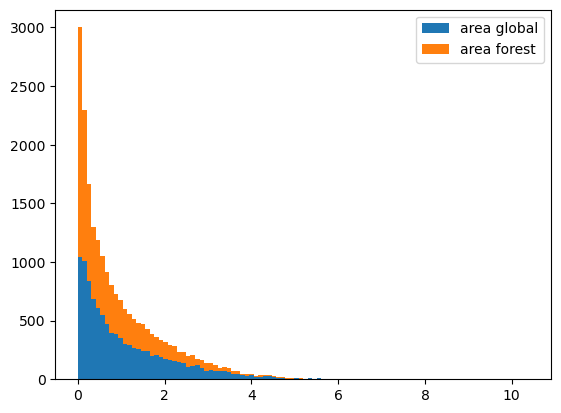

In [48]:
ax = plt.subplot()
ax.hist(df[['area_1981_2010_1e6km2_global', 'area_1981_2010_1e6km2_forest']], 100, stacked=True, fill=True, label=['area global', 'area forest'])
ax.legend()
#plt.yscale('log',base=10) 
plt.show()

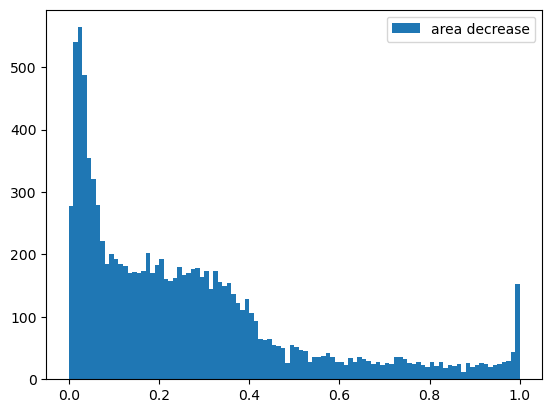

In [49]:
ax = plt.subplot()
ax.hist(df['area_decrease'], 100, fill=True, label=['area decrease'])
ax.legend()
#plt.yscale('log',base=10) 
plt.show()